# Slice 3D TBP Analysis, Data Cleaning, Preprocessing Notebook
### Lucas Chin, Daanesh Bogale, Tiffany Lai, Brayden Weimholt

Loading Process:

In [24]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import seaborn as sns
from matplotlib import pyplot as plt
import h5py
import io
from PIL import Image



In [25]:
dir = "isic-2024-challenge"
train_df = pd.read_csv(f"{dir}/train-metadata.csv")
train_img = f"{dir}/train-image/image"
train_hdf5 = f"{dir}/train-image.hdf5"


/var/folders/fd/fljdz0px6q306ncxtn22z25w0000gn/T/ipykernel_31225/4260426400.py:2: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(f"{dir}/train-metadata.csv")


# Data Cleaning and Preprocessing

We'll begin by checking to see the counts of null values noticed by pandas for each given feature.

In [26]:
null_counts = train_df.isnull().sum().sort_values(ascending=False).iloc[0:13]
print(null_counts, "\n\nOutput cut to ignore redundant columns with no null realizations.")

iddx_5                         401058
mel_mitotic_index              401006
mel_thick_mm                   400996
iddx_4                         400508
iddx_3                         399994
iddx_2                         399991
lesion_id                      379001
sex                             11517
anatom_site_general              5756
age_approx                       2798
tbp_lv_norm_color                   0
tbp_lv_stdL                         0
tbp_lv_radial_color_std_max         0
dtype: int64 

Output cut to ignore redundant columns with no null realizations.


The features that have mostly null attributes are the iddx (iddx_5, iddx_4, iddx_3, iddx_2) columns, the melonama mitotic index and the melanoma thickness in millimeters, and the lesion_id. Sex, anatomy site, and age approximation all have way less (but still significant, three to eleven thousand) NaN values.

For the iddx 5, 4, 3, and 2 columns, barely any of the units in the data even have values for it. Since the values that are stored here are super variable--due to them being strings describing (very technically) the lesion--and only a few possess it, we may as well drop these columns from the data.

Without Natural Language Processing help, it'd be very difficult to transform the strings into meaningful information/numbers we can interact with and model for interpretation.

Also, we can ignore the lesion_id column since barely any units have it and we already have a primary identifier for each lesion: isic_id. There's another potential one too, the patient_id. Therefore, we don't need a useless identifier.

In [27]:
train_df['iddx_1'].value_counts()

iddx_1
Benign           400552
Malignant           393
Indeterminate       114
Name: count, dtype: int64

Though iddx_1 is simple, and only will tell you if the lesion is Benign, Malignant, or indeterminate, we can't use this feature for modeling since it pretty much is what we want to model! This would be circular reasoning, so let's drop this iddx_1.

Similar to iddx_ 2, 3, 4, 5, iddx_full uses all the descriptions from the iddx to create a combined lesion description. Without NLP, we can't mathematically represent this too easily, so it may be best to drop it. Therefore, we drop the iddx columns.

Since we're modelling the probability of a lesion being benign/malignant (target = 0/1 respectively), and we're attempting to avoid circular reasoning, basing the probability of one's lesion being malignant or not on their melanoma's thickness and mitocity index would be a clear violation of the model. A melanoma is most definitely a malignant lesion, so for the same reason we leave out iddx_1 and it's sister variables, we leave out mel_thick_mm and mel_mitotic_index.

**Columns/Features to drop: iddx_full, iddx_1, iddx_2, iddx_3, iddx_4, iddx_5, mel_thick_mm, mel_mitotic_index, lesion_id**

The only other features with NA values are age_approx, sex, and anatom_site_general. They don't have nearly enough NA values fortunately, with their proportions ranging from ~1 - 3% of the overall sample size.

For sex we have the most missing values with about 11,500 people--though it's sizable, the partition size isn't enough to warrant the addition of an "unknown" sex category and more complexity for our model/neural network. For this reason, we have decided to drop the sampling units who refused to state their sex, as we have a suspicion it may be an important factor in determining why a given lesion may be harmful or not.

Anatomy site has half the missing values as sex, and already has a bunch of covariates to approximate--adding one more variable to that covariance matrix (unknown) would increase the model complexity/run time in a worse way, so we'll drop these units from the study as well.

For age, there are even less NA values, so to keep some of these sampling units with us, it may not be that much of an overfit to impute the median, letting NA units take on an average case of age to still bring in the relevance of their other statistics.

**Columns/Features to Clean: anatom_site_general, sex (clean/remove NA units), age_approx (impute median)**

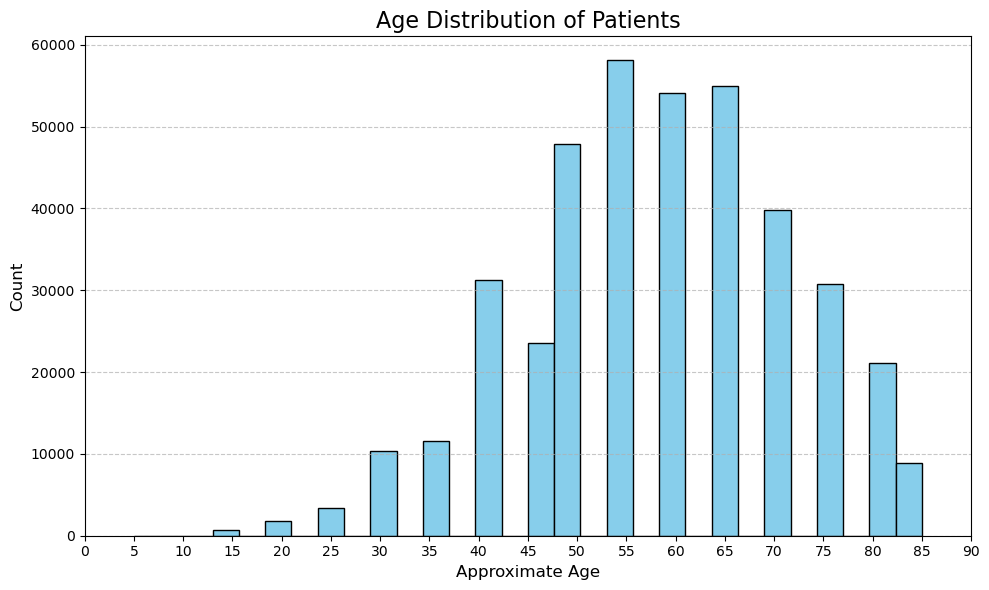

In [28]:
plt.figure(figsize=(10, 6))
plt.hist(train_df['age_approx'], bins=30, color='skyblue', edgecolor='black')
plt.title('Age Distribution of Patients', fontsize=16)
plt.xlabel('Approximate Age', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(0, 91, 5))
plt.tight_layout()
plt.show()

As we see in the Age Distribution of Patients histogram, we found that the distribution is slightly left-skewed, meaning that there are more older patients than younger ones. The majority of the patient is between 40 to 70 years old, with a peak around age 55. Therefore, the lesion risk increases with age, increasing the propensity for a malignant lesion (since more skin cancer lesions pop up).

Let's see how this reacts to the cleaning process. which imputes the median age into NA values (instead of ignoring):

In [29]:
train_df.drop(columns=['iddx_full', 'iddx_1','iddx_2', 'iddx_3','iddx_4', 'iddx_5', 'lesion_id', 'mel_mitotic_index', 
                       'mel_thick_mm'], inplace=True)

train_df = train_df[train_df['sex'].notna()] # removes empty sex units from the df
train_df = train_df[train_df['anatom_site_general'].notna()] # removes empty anatomy loc units

median_age = train_df['age_approx'].median()
train_df['age_approx'] = train_df['age_approx'].fillna(median_age) # imputes median


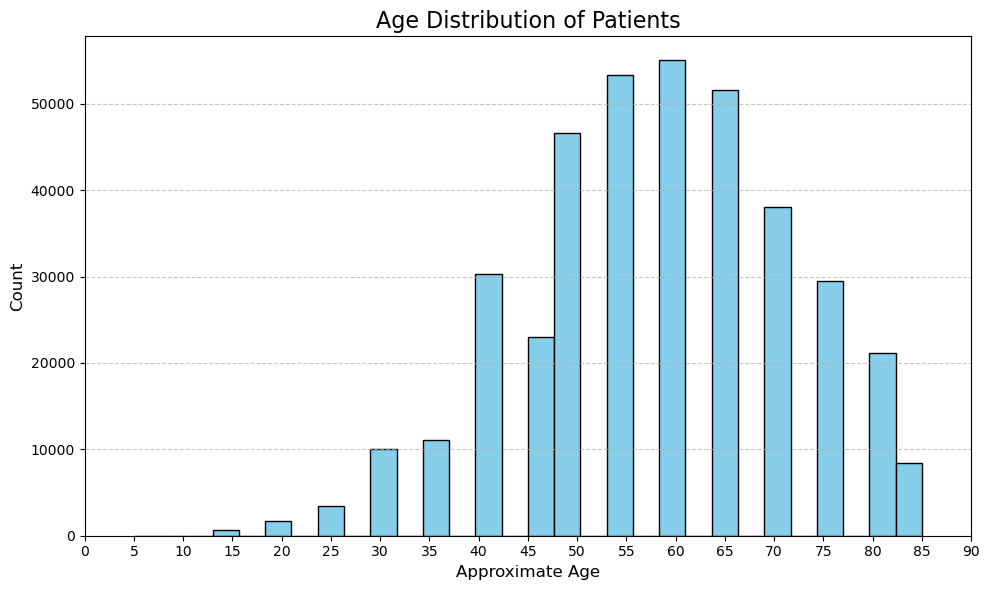

In [30]:
plt.figure(figsize=(10, 6))
plt.hist(train_df['age_approx'], bins=30, color='skyblue', edgecolor='black')
plt.title('Age Distribution of Patients', fontsize=16)
plt.xlabel('Approximate Age', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(0, 91, 5))
plt.tight_layout()
plt.show()

After cleaning the data, we can observe that the histogram is more normally distributed. The median that we get from the age is around 60. We will get that same skewed distribution, though it does increase the peak of age of 55 to age 60 (the median). Therefore, since we have a very similiar distribution after imputing the median, we can assume that our model will not be overfitted too much. 

**Cleaning now is complete. Time to write this to a CSV for training and then continue navigating the database!**

In [31]:
train_df.to_csv('clean-metadata.csv')

# Exploratory Data Analysis

Now that we have the data ready, we now have wind in the neural network's sails! As it fights against the thrashing sea of overfitting, bugs, complex picture data, and more, we can run some more analysis on the data. 

By using logistic regression models, plots and histograms to view associations/correlations/distributions of features, restratifying the data, and much more, we're acting as Poseidon, easing the water for our fellow navymen. It's always nice to begin with a simple summary:

In [32]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
target,383794.0,0.000998,0.031574,0.000000e+00,0.000000,0.000000,0.000000,1.000000
age_approx,383794.0,58.002913,13.635783,5.000000e+00,50.000000,60.000000,70.000000,85.000000
clin_size_long_diam_mm,383794.0,3.932716,1.744515,1.000000e+00,2.840000,3.370000,4.380000,28.040000
tbp_lv_A,383794.0,19.947349,3.986157,-2.487115e+00,17.317961,19.776896,22.266407,48.189610
tbp_lv_Aext,383794.0,14.903476,3.512652,-9.080269e+00,12.467986,14.702400,17.113810,37.021680
tbp_lv_B,383794.0,28.175756,5.231800,-7.309895e-01,24.639370,28.075192,31.495537,54.306900
tbp_lv_Bext,383794.0,26.809768,4.438267,9.237066e+00,23.785118,26.607315,29.533412,48.372700
tbp_lv_C,383794.0,34.683522,5.664307,3.054228e+00,30.935337,34.729229,38.293990,58.765170
tbp_lv_Cext,383794.0,30.822631,4.783256,1.184652e+01,27.595338,30.716017,33.835930,54.305290
tbp_lv_H,383794.0,54.593470,5.510468,-1.574164e+00,51.519929,54.976662,58.227428,105.875784


The average/mean target is about 0.001, meaning that it's very unlikely for a random person to possess cancerous lesions. The standard deviation is quite small as well, corroborating this claim--the confidence interval for target's mean is probably wrapping that 0.001 average very tightly.

The features with high standard deviation, and probably higher p-values, are age approximation, the luminance/light inside and outside the lesion, the base area of the lesion in $mm^2$, the base perimeter of the lesion in $mm^2$, the symmetric axis angle of the lesion, and the nevi confidence scale.

Maybe the way we bin the ages by 5's is reducing the significance of age. Maybe the perimeter and area themselves don't matter--this would make sense, since their ratio actually is relatively significant. Maybe the nevi confidence scale they use is actually a bad predictor of a lesion; that's what we're here to figure out. Let's see how some of these variables fair against each other.

The more important thing to note from this are features that the CNN would utilize to deconstruct the image and classify it. The pixels are analyzed for their color and difference from one another, as well as the size of the spot, and how it is position

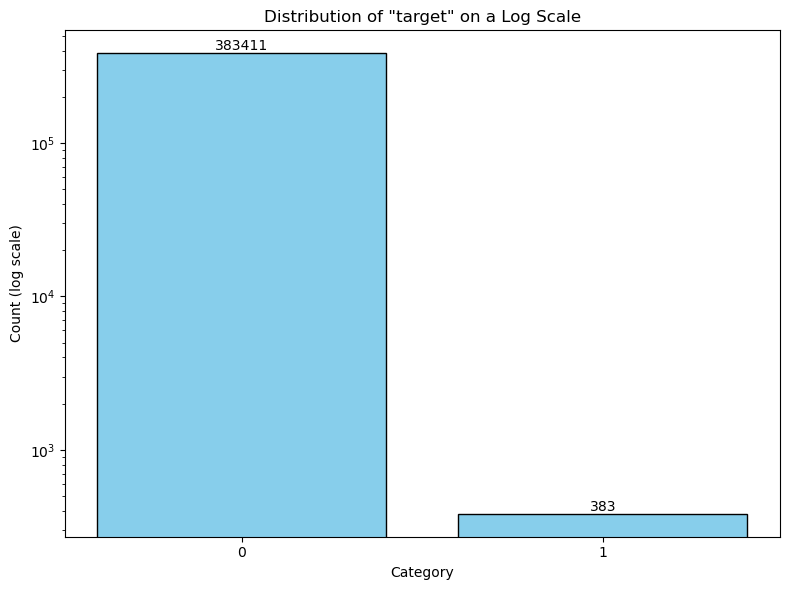

In [33]:
def plot_target_log_distribution(df, target_column='target'):
    """
    Plots the distribution (bar chart) of a categorical target variable on a log scale.
    
    Parameters:
      - df: pandas DataFrame that contains the target column.
      - target_column: name of the column in df that holds the categorical target (default is 'target').
    
    The function computes the count of each category and then displays a bar chart with 
    the y-axis scaled logarithmically.
    """
    # Compute frequency counts for each category
    counts = df[target_column].value_counts()
    
    # Create the bar chart
    plt.figure(figsize=(8, 6))
    bars = plt.bar(counts.index.astype(str), counts.values, color='skyblue', edgecolor='black')
    plt.yscale('log')  # Set the y-axis to log scale
    
    # Add labels and title
    plt.xlabel("Category")
    plt.ylabel("Count (log scale)")
    plt.title(f'Distribution of "{target_column}" on a Log Scale')
    
    # Optionally add the count above each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}',
                 ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

plot_target_log_distribution(train_df)

We'll use the log-scale on the y-axis to help see the smaller values easier--we have only 393 malignant cases compared to almost 401,000 total lesions.

NameError: name 'Patch' is not defined

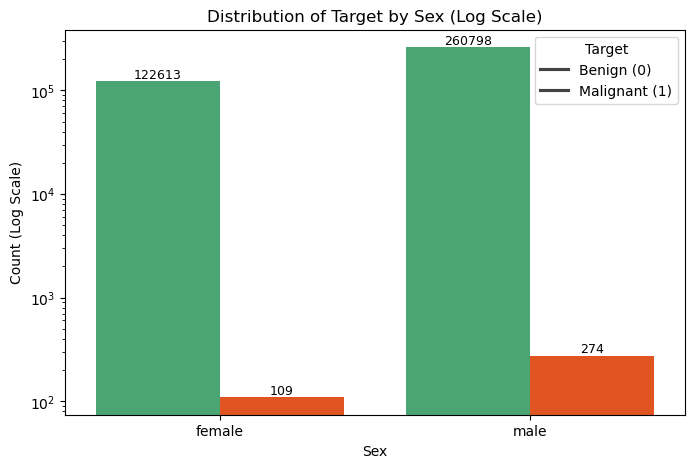

In [105]:
def plot_sex_target_distribution(df):
    """
    Plots the bar chart distribution of target values for each entry in the
    'sex' column from the given DataFrame.
    
    Parameters:
        df (pd.DataFrame): The input dataframe. Must include 'sex' and 'target' columns.
    """
    # Count values grouped by sex and target
    counts = df.groupby('sex')['target'].value_counts().rename('count').reset_index()

    # Plot
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=counts, x='sex', y='count', hue='target',
                     palette={0: 'mediumseagreen', 1: 'orangered'})

    # Log scale
    ax.set_yscale('log')

    # Annotate values
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9)

    # Customize
    plt.title("Distribution of Target by Sex (Log Scale)")
    plt.ylabel("Count (Log Scale)")
    plt.xlabel("Sex")
    plt.legend(title="Target", labels=["Benign (0)", "Malignant (1)"])
    legend_labels = [Patch(facecolor='mediumseagreen', label='Benign (0)'),
                    Patch(facecolor='orangered', label='Malignant (1)')]
    plt.legend(handles=legend_labels, title="Target")
    plt.tight_layout()
    plt.show()

plot_sex_target_distribution(train_df)

Comparing sexes and their malignant lesion counts shows that males receive more cancerous lesions than females. Let's see how this compares to the way different general anatomy groups' counts contrast.

NameError: name 'Patch' is not defined

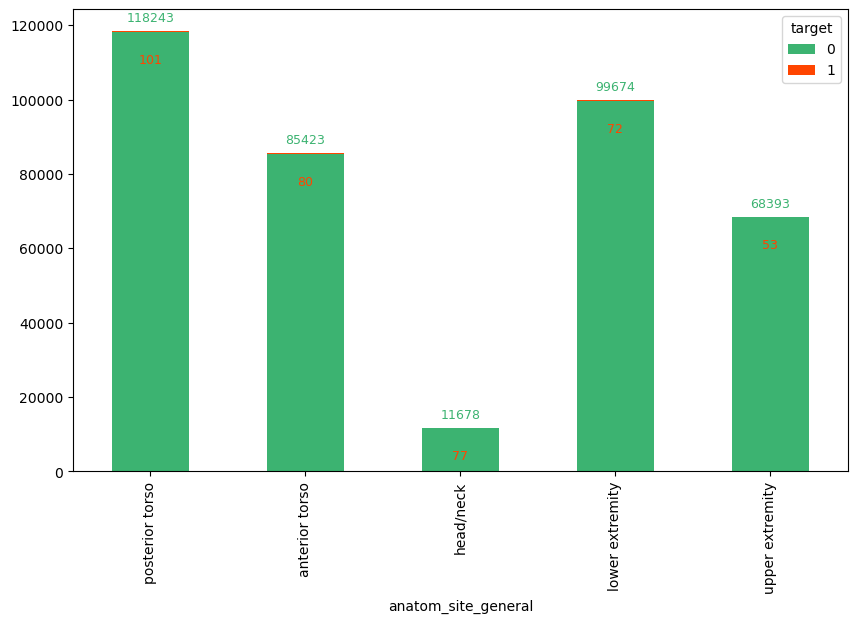

In [106]:
def plot_anatom_site_target_distribution(df):
    """
    Plots the bar chart distribution of target values for each entry in the
    'anatom_site_general' column from the given DataFrame.
    
    Parameters:
        df (pd.DataFrame): The input dataframe. Must include 'anatom_site_general' and 'target' columns.
    """
    # Verify required columns exist
    required_columns = ['anatom_site_general', 'target']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"The DataFrame must include a '{col}' column.")
    
    # Group by 'anatom_site_general' and 'target', count occurrences and reshape
    grouped = df.groupby(['anatom_site_general', 'target']).size().unstack(fill_value=0)
    grouped = grouped.sort_values(0 + 1 if 1 in grouped.columns else 0, ascending=False)

    fig, ax = plt.subplots(figsize=(10, 6))
    colors = {0: 'mediumseagreen', 1: 'orangered'}
    grouped.plot(kind='bar', stacked=True, ax=ax, color=[colors.get(i) for i in grouped.columns])

    # Add value labels only for visible bars
    for i, container in enumerate(ax.containers):
        bar_color = container.patches[0].get_facecolor()  # FIXED LINE
        labels = [f'{int(v)}' if v > 0 else '' for v in container.datavalues]
        pad = 5 if i == 0 else -25  # Adjust label position based on layer
        ax.bar_label(container, labels=labels, label_type='edge', fontsize=9, padding=pad, color=bar_color)

    # Legend with patches
    legend_labels = [
        Patch(facecolor='mediumseagreen', label='Benign (0)'),
        Patch(facecolor='orangered', label='Malignant (1)')
    ]
    ax.legend(handles=legend_labels, title="Target")

    # Titles and axis formatting
    plt.title("Distribution of Skin Lesions by Anatomical Site (Log Scale)", fontsize=13)
    plt.ylabel("Count (Log Scale)")
    plt.xlabel("Anatomical Site")
    plt.yscale('log')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_anatom_site_target_distribution(train_df)

Even with a log scale, we can barely see any counts for the 5 groups. Their counts can't be larger than 393 (the total malignant cases), so it makes sense that, even on the log scale, their realistic values of 10-80ish won't be seen as well. Let's look deeper into the general locations and see where lesions might be the most dangerous on the body.

In [ ]:
summary = train_df.groupby(['anatom_site_general', 'tbp_lv_location_simple', 'tbp_lv_location']) \
.agg(
count=('target', 'count'), malignant=('target', 'sum'), malignancy_rate=('target', 'mean')
).reset_index()
summary_sorted = summary.sort_values( by=['malignancy_rate', 'malignant', 'count'], ascending=False
).reset_index(drop=True)
summary_sorted.insert(0, 'Rank', summary_sorted.index + 1)
summary_sorted.head(10)

,Rank,anatom_site_general,tbp_lv_location_simple,tbp_lv_location,count,malignant,malignancy_rate
0,1,head/neck,Head & Neck,Head & Neck,11755,77,0.006550
1,2,lower extremity,Left Leg,Left Leg,1870,5,0.002674
2,3,upper extremity,Left Arm,Left Arm,1510,2,0.001325
3,4,anterior torso,Torso Front,Torso Front Top Half,61758,67,0.001085
4,5,lower extremity,Right Leg,Right Leg - Lower,24444,24,0.000982
5,6,upper extremity,Left Arm,Left Arm - Lower,11597,11,0.000949
6,7,posterior torso,Torso Back,Torso Back Top Third,69116,65,0.000940
7,8,lower extremity,Left Leg,Left Leg - Lower,26602,24,0.000902
8,9,posterior torso,Torso Back,Torso Back Bottom Third,4537,4,0.000882
9,10,upper extremity,Left Arm,Left Arm - Upper,22199,19,0.000856


These proportions, while small, are definitely different than each other and significant. The head and neck region is the most dangerous, with a proportion of 0.0065 of the lesions being cancerous (77 out of 11755)--0.65% of their marks are malignant. Let's view just how different these danger rates are.

/var/folders/3_/vryb3cvs6cjffdgbdr66z8dw0000gn/T/ipykernel_2344/3500299777.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_locations, x='malignancy_rate', y='Location (Ranked)', palette='Reds_r')


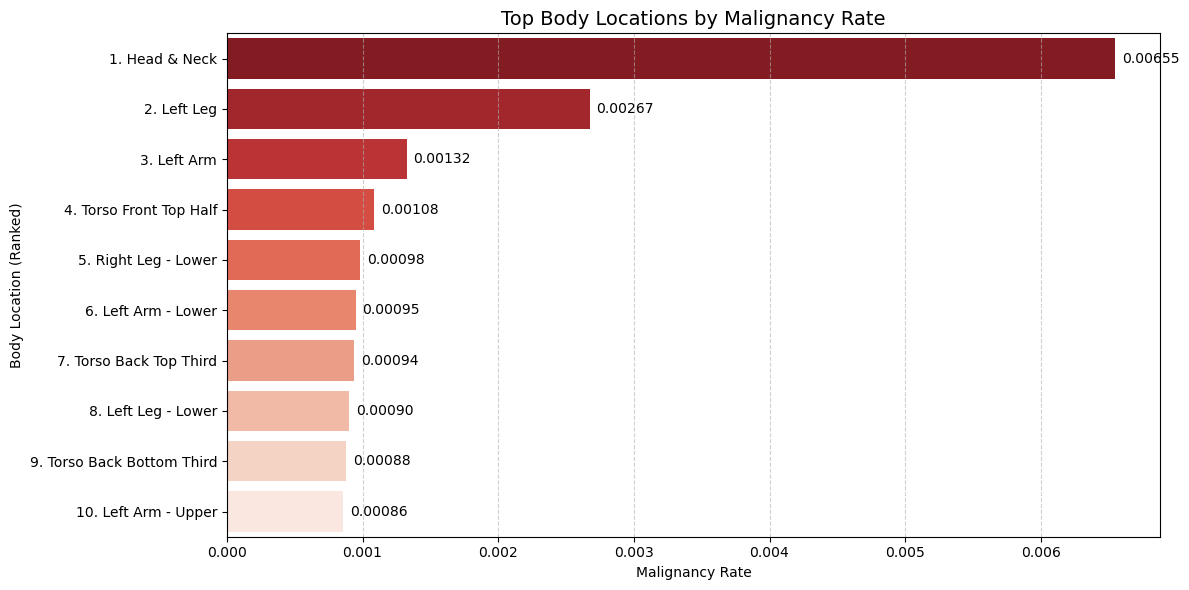

In [ ]:
top_n = 10
top_locations = summary_sorted.head(top_n).copy()
top_locations['Location (Ranked)'] = top_locations.apply(lambda row: f"{row['Rank']}. {row['tbp_lv_location']}", axis=1 )
plt.figure(figsize=(12, 6))
sns.barplot(data=top_locations, x='malignancy_rate', y='Location (Ranked)', palette='Reds_r')
for i, row in top_locations.iterrows():
    plt.text(row['malignancy_rate'] + 0.00005, i, f"{row['malignancy_rate']:.5f}",va='center')
plt.title('Top Body Locations by Malignancy Rate', fontsize=14)
plt.xlabel('Malignancy Rate')
plt.ylabel('Body Location (Ranked)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Rates/proportions of the malignant cases don't seem to vary too much outside of the top 3 danger regions.

It'll be good to keep this in mind while working through the data--the left arm and leg, and the head and neck general area are the most dangerous, though head and neck has the highest rate by a long shot; over double the next highest, left leg.

We saw before that the Std. Dev ($\sigma$) of the area and perimeter were insignificant, but the ratio seemed to be. We can take a look at a scatterplot of every observations' area:perimeter mm^2 ratio VS. the longest possible diameter of the lesion in mm.

For correlations, we can plot how each variable is correlated to target and see some more information about which features may be worth giving weight in the model/neural network.

We can also model a heatmap of every feature's correlation with each other in a correlation matrix, determining where we might see some covariance and underestimated standard deviations, which might be giving false significance to some features. This will show some multicollinearity, and allow us to remove some redundance in the model, maybe giving space for some other predictors to shine.

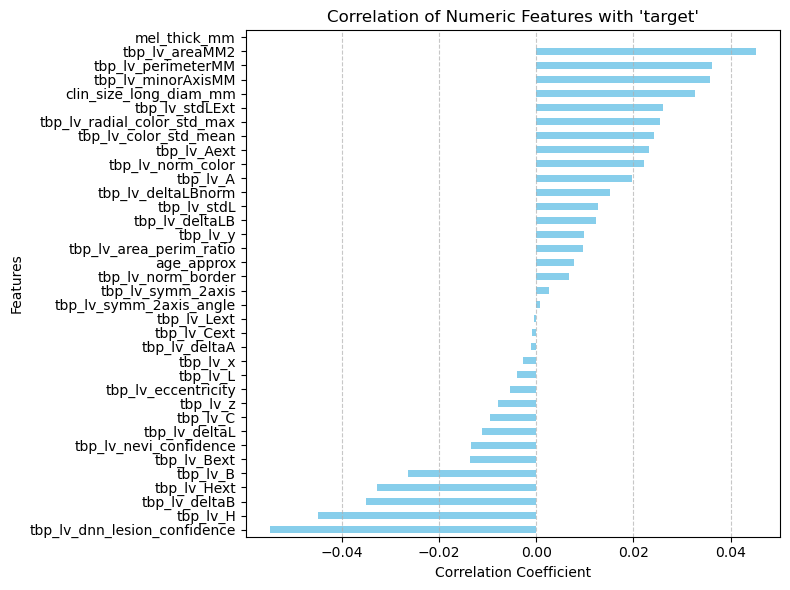

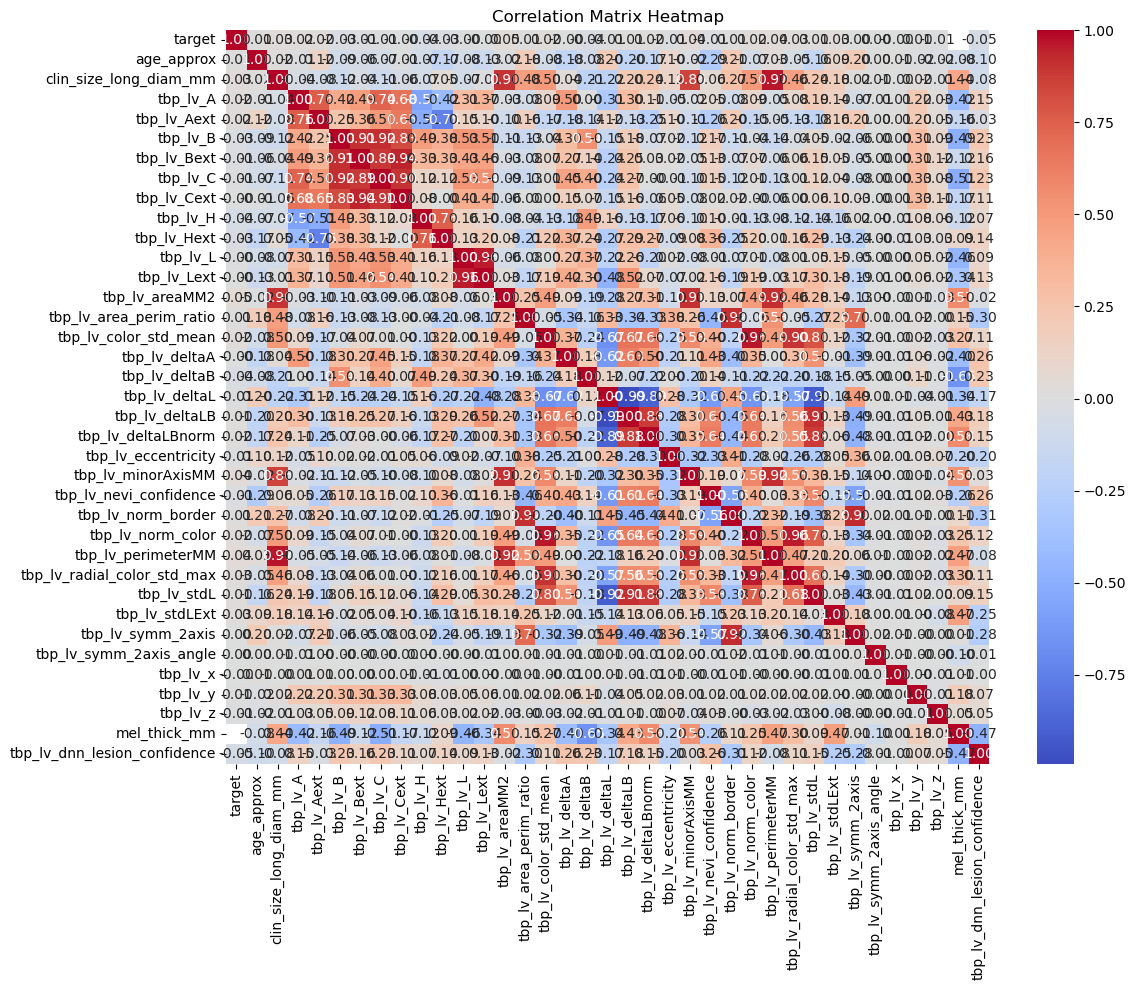

In [ ]:
def plot_target_correlations(df, target='target'):
    """
    Computes and plots the correlation of numeric features with the target variable.
    
    This function performs the following:
      - Selects only numeric columns from the DataFrame.
      - Computes the correlation matrix of these columns.
      - Extracts the correlation of each feature with the target.
      - Creates a horizontal bar chart of these correlations.
      - Plots the full correlation matrix as a heatmap.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing your data.
        target (str): The name of the target column (must be numeric).
    """
    
    # Ensure the target column exists
    if target not in df.columns:
        raise ValueError(f"The DataFrame must include a '{target}' column.")
    
    # Select numeric features
    numeric_df = df.select_dtypes(include=['number'])
    
    # Ensure that target is numeric for correlation
    if target not in numeric_df.columns:
        raise ValueError("Target column is not numeric; cannot compute correlation.")

    # Compute the correlation matrix
    corr_matrix = numeric_df.corr()

    # Extract correlations with the target column (dropping target itself)
    target_corr = corr_matrix[target].drop(labels=[target])
    
    # Option 1: Horizontal Bar Chart of correlations with the target
    plt.figure(figsize=(8, 6))
    target_corr.sort_values().plot(kind='barh', color='skyblue')
    plt.title(f"Correlation of Numeric Features with '{target}'")
    plt.xlabel("Correlation Coefficient")
    plt.ylabel("Features")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Option 2: Full Correlation Matrix Heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.tight_layout()
    plt.show()

plot_target_correlations(train_df)

Removing these multicollinear columns using numpy to filter numeric columns and kick out the column of correlations in the top right > 0.9, we can reduce the complexity of the model while telling a very similar story, if you will.

In [119]:
numeric_df = train_df.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = numeric_df.corr().abs()

# Get upper triangle (to avoid duplicate checks)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find columns with correlation > 0.9
to_drop_auto = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop them from the dataframe
train_df_cleaned = train_df.drop(columns=to_drop_auto)

print(f"Highly correlated features dropped: {to_drop_auto}")

Highly correlated features dropped: ['tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_deltaLB', 'tbp_lv_minorAxisMM', 'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_symm_2axis']


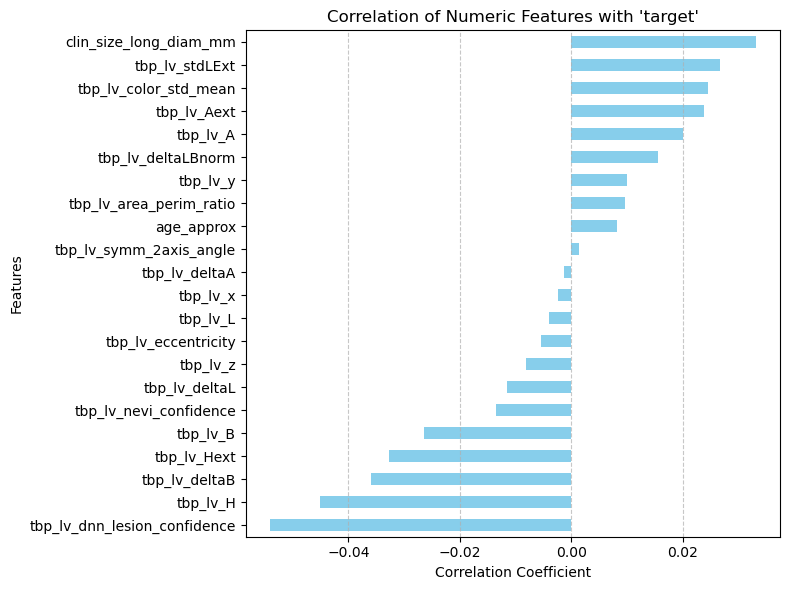

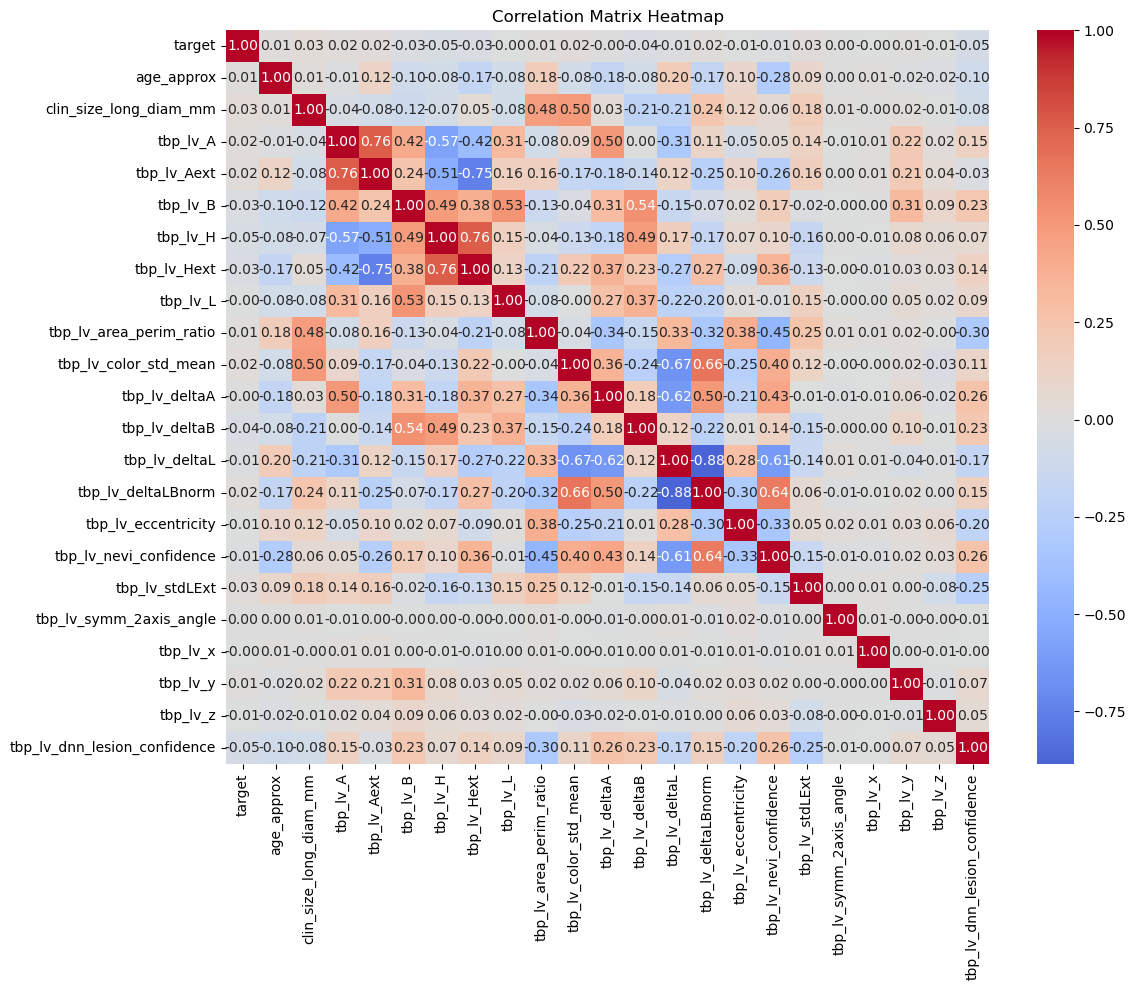

In [100]:
plot_target_correlations(train_df_cleaned)

 The correlation matrix is much more spread out and dull, meaning we reduced that multicollinearity a lot.Removing confidence indicators the biostatisticians input, we follow the features the CNN in model.ipynb deem important in it's classifications to better understand how a model would look under these explanatory variables.

In [120]:
import statsmodels.api as sm

X = train_df_cleaned.select_dtypes(include=[np.number]).drop(
    columns=['target', 'tbp_lv_nevi_confidence', 'tbp_lv_dnn_lesion_confidence'], errors='ignore'
)
y = train_df['target']

X_const = sm.add_constant(X)

logit_model = sm.Logit(y, X_const)
result = logit_model.fit()

summary_df = pd.DataFrame({
    'feature': result.params.index,
    'coefficient': result.params.values,
    'p_value': result.pvalues.values
}).sort_values(by='p_value')

top_10_significant = summary_df[summary_df['feature'] != 'const'].head(10)

print("🔍 Top 10 statistically significant features (by p-value):")
print(top_10_significant)

         Current function value: 0.006538
         Iterations: 35
🔍 Top 10 statistically significant features (by p-value):
                    feature  coefficient       p_value
2    clin_size_long_diam_mm     0.237364  8.005475e-31
19                 tbp_lv_y     0.000981  1.877913e-10
16           tbp_lv_stdLExt     0.271393  2.782461e-10
8                  tbp_lv_L     0.047199  2.684857e-07
9   tbp_lv_area_perim_ratio    -0.061246  5.380087e-07
10    tbp_lv_color_std_mean     0.328789  2.558963e-06
13            tbp_lv_deltaL     0.221014  1.219136e-05
5                  tbp_lv_B    -0.219495  6.547193e-05
14       tbp_lv_deltaLBnorm     0.228704  6.532161e-04
1                age_approx     0.009292  2.239888e-02


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



This model definitely has some significant covariates, so it's worth diving deeper to see how well it actually classifies.


Top influential features in the logistic model:
tbp_lv_y                   0.404350
tbp_lv_H                  -0.387017
clin_size_long_diam_mm     0.371374
tbp_lv_B                  -0.316645
tbp_lv_L                   0.260847
tbp_lv_color_std_mean      0.253515
tbp_lv_Hext               -0.246881
tbp_lv_area_perim_ratio   -0.244908
tbp_lv_deltaB             -0.242724
tbp_lv_deltaL              0.194320
dtype: float64


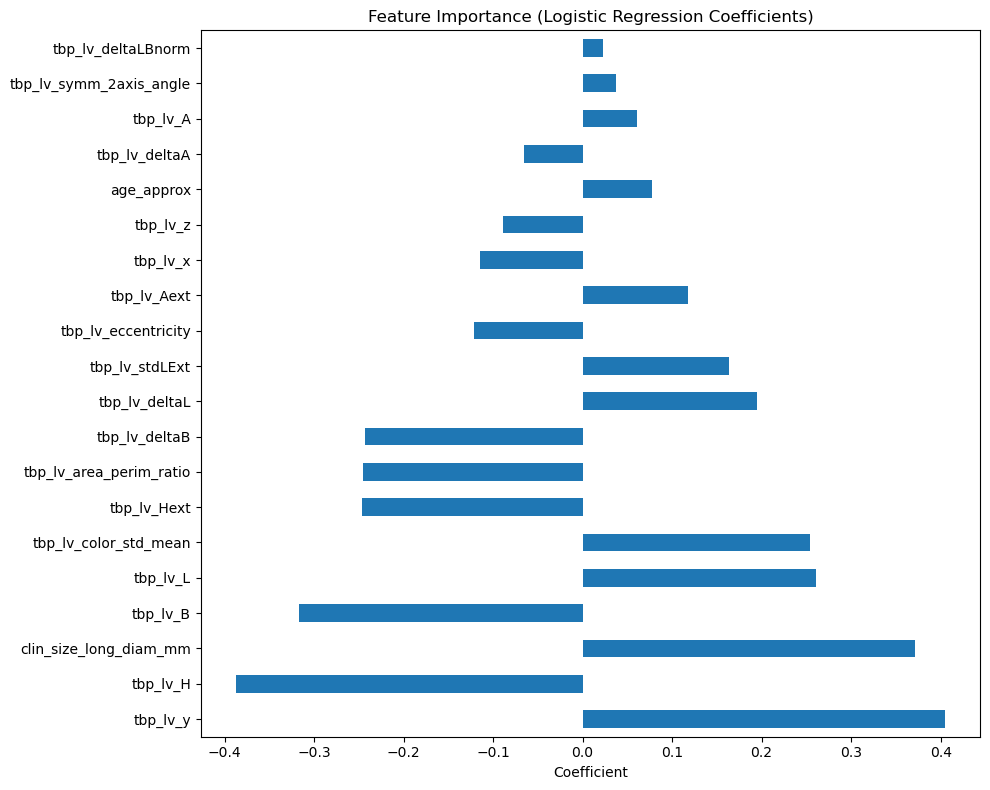

In [121]:

X = train_df_cleaned.select_dtypes(include=[np.number]).drop(columns=['target', 'tbp_lv_nevi_confidence',  'tbp_lv_dnn_lesion_confidence', ], errors='ignore')
y = train_df['target']

X = X.select_dtypes(include=[np.number])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train)
coefs = pd.Series(clf.coef_[0], index=X.columns).sort_values(key=np.abs, ascending=False)

print("\nTop influential features in the logistic model:")
print(coefs.head(10))

plt.figure(figsize=(10, 8))
coefs.plot(kind='barh')
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()

This plot shows the coefficients for the change in log odds for the logistic regression model, and specifically the most powerful ones from our more clean, numeric data being used.

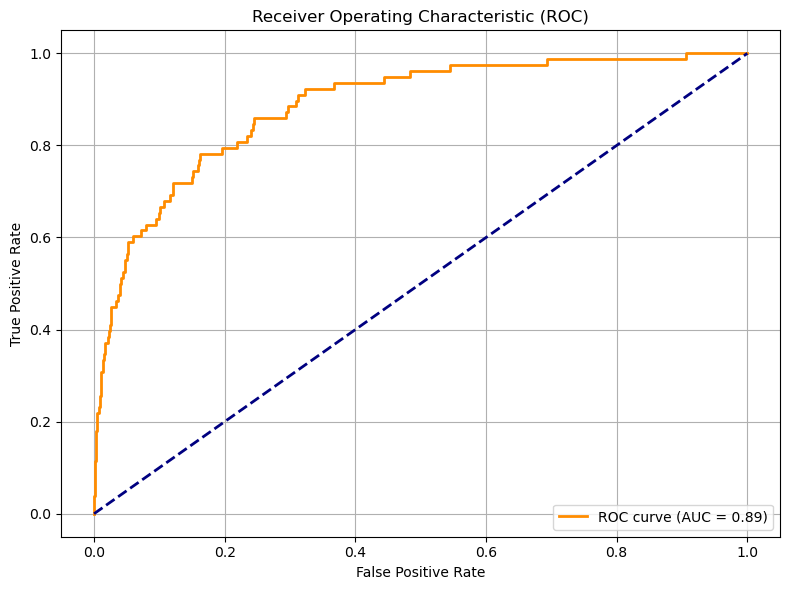

In [112]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

X_test_scaled = scaler.transform(X_test)

y_probs = clf.predict_proba(X_test_scaled)[:, 1] 

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

So while the false positive rate is low, the model is fixed to not be setting too many benign cases as malignant, and fortunately our model guesses better with higher TPR/sensitivy as this starts to increase. This means that while we're not flagging lesions as cancer that aren't too much, we do guess who is cancerous. As we start to flag lesions as cancerous wrongfully more and more, the model may overguess cancers but definitely strarts getting the real ones even more.

The model trained on statsmodel.api was able to use it's estimations and extra memory to estimate p-values for significance, and the model trained on scikit learn was able to output covariate estimates quick and easily as well as create an ROC plot with it AUC value there.

In [ ]:
#Decode an image with its ISIC id
def decode_isic_image(isic_id, file_path, num_channels=3, as_array=False):
    """
    Decodes an ISIC image from an HDF5 file.

    The HDF5 file is expected to store images with keys corresponding to their ISIC IDs.
    The image can be stored either as encoded bytes (JPEG, PNG, etc.) or as a raw NumPy array.

    Parameters:
        isic_id (str): The ISIC identifier referencing the image in the HDF5 file.
        file_path (str): The path to the HDF5 file.
        num_channels (int): The expected number of channels in the image. For example, 1 for grayscale,
                            3 for RGB, or 4 for RGBA.
        as_array (bool): If True, returns a NumPy array; otherwise returns a PIL Image (default).

    Returns:
        PIL.Image.Image or numpy.ndarray: The decoded image.

    Raises:
        ValueError: If the image cannot be found or decoded, or if the image channels do not
                    match the expected number.
    """
    # Open the HDF5 file and retrieve the image using its ISIC ID.
    with h5py.File(file_path, "r") as hf:
        try:
            # Adjust this line if the images are stored under a subgroup (e.g., hf['images'][isic_id]).
            data = hf[isic_id][()]
        except KeyError:
            raise ValueError(f"Image with ISIC ID '{isic_id}' not found in the HDF5 file.")

    # Case 1: The data is stored as encoded image bytes.
    if isinstance(data, bytes):
        image = Image.open(io.BytesIO(data))

    # Case 2: The data is stored as a raw NumPy array.
    elif isinstance(data, np.ndarray):
        # If the image is grayscale (2D array) and one channel is expected:
        if data.ndim == 2 and num_channels == 1:
            image = Image.fromarray(data, mode='L')
        # For color images, we expect a 3D array.
        elif data.ndim == 3:
            if data.shape[2] == num_channels:
                if num_channels == 1:
                    # Squeeze the extra dimension for grayscale.
                    image = Image.fromarray(data.squeeze(), mode='L')
                elif num_channels == 3:
                    image = Image.fromarray(data, mode='RGB')
                elif num_channels == 4:
                    image = Image.fromarray(data, mode='RGBA')
                else:
                    # For uncommon channel counts, fall back to default conversion.
                    image = Image.fromarray(data)
            else:
                raise ValueError(f"Expected {num_channels} channels, but found {data.shape[2]} channels in the image data.")
        else:
            raise ValueError("Unsupported image data shape in the HDF5 file.")

    # Case 3: Attempt to convert any other type to bytes and decode.
    else:
        try:
            data_bytes = bytes(data)
            image = Image.open(io.BytesIO(data_bytes))
        except Exception as e:
            raise ValueError("Could not decode image from the HDF5 file data.") from e

    if as_array:
        return np.array(image)
    else:
        return image


decoded_image = decode_isic_image("ISIC_0015670", train_hdf5, num_channels=3, as_array=False)
decoded_image.show()